In [18]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from sasdata.dataloader.loader import Loader 
from bumps.names import FitProblem, FreeVariables
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment

In [19]:
# Following are most likely spherical micelles with a PHFBA core and PDEGEEA corona
TESTING = True 
SLD_CORE = 1.85
SLD_CORONA = 0.817
SLD_SOLVENT_LIST = {'dTHF': 6.349, 'THF': 0.183, 'D2O':6.36, 
'H2O':-0.561, 'dCF': 3.156, 'dTol':5.664, 'dAcetone':5.389,
'dTHF0':6.360, 'dTHF25':6.357, 'dTHF50':6.355, 'dTHF75':6.352,'hTHF':1.0
}

block_params = {'DEG': {'density':1.1, 'MW':188.22},
                'PEG': {'density':1.09, 'MW': 480.0},
                'F': {'density':1.418, 'MW':254.10}
                } 
DOP = {'DEG50F25' : (45, 30), # (EG, F)
       'DEG50F25b': (48, 27), 
       'DEG50F50' : (48, 52),
       'DEG50F75' : (46.25, 78.75),
       'PEG50F25' : (41.25, 33.75),
       'PEG50F50' : (50, 50)
       }
Navg = 6.02e23 
conversion = 1e24
block_vols = {}
for key, value in block_params.items():
    block_vols[key] = conversion*((value['MW']/value['density'])/Navg)

NUM_STEPS = 2 if TESTING else 5e2

SI_FILE_LOC = './EXPTDATA_V2/sample_info_OMIECS.csv'
DATA_DIR = './EXPTDATA_V2/inco_bg_sub/'

In [20]:
def load_data_from_file(fname):
    SI = pd.read_csv(SI_FILE_LOC)
    flag = SI["Filename"]==fname
    metadata = SI[flag]
    loader = Loader()
    data = loader.load(DATA_DIR+'%s'%fname)[0]
    
    data.qmin = min(data.x)
    data.qmax = data.x[-metadata['Highq_trim']] 
    data.mask = (np.isnan(data.y) if data.y is not None
                         else np.zeros_like(data.x, dtype='bool'))
    
        
    return data, metadata

In [21]:
FIT_KEYS = [116,118,129,125,127,132,134,135,136,138,139,140,931,932,933,964,965,970,971] 
BLOCK_KEYS = [('DEG', '25b'), ('DEG', '50'), ('DEG', '75'), ('PEG', '25'), ('PEG', '50')]
FIT_BLOCK_KEY = ('DEG', '25b') 
SIMUL_FILENAMES = [] 
SI = pd.read_csv(SI_FILE_LOC)
for key, values in SI.iterrows():
        if values['Sample'] in FIT_KEYS:
                if (values['EG_group']==FIT_BLOCK_KEY[0] and values['Flor_block']==FIT_BLOCK_KEY[1]):
                    fname = values['Filename']
                    SIMUL_FILENAMES.append(fname)
                    print(fname,values['EG_group'], values['Flor_block'])


D50F25b_10dTol.sub DEG 25b
D50F25b_10dTHF75.sub DEG 25b


In [22]:
datasets = []
metadatasets = []
for f in SIMUL_FILENAMES:
    data, metadata = load_data_from_file(f)
    datasets.append(data)
    metadatasets.append(metadata)

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F25b_10dTol.sub'
Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise

In [23]:
def setup_model():
    sas_model = load_model("../models/spherical_micelle.py")
    bumps_model = Model(model=sas_model)
    bumps_model.scale.range(1e-15, 1e-5)
    # use default bounds
    bumps_model.v_core.fixed = True 
    bumps_model.v_corona.fixed = True
    bumps_model.n_aggreg.fixed = True
    # use fixed values
    bumps_model.background.fixed = True 
    bumps_model.background.value = 0.0
    bumps_model.sld_core.fixed = True 
    bumps_model.sld_core.value = SLD_CORE
    bumps_model.sld_corona.fixed = True 
    bumps_model.sld_corona.value = SLD_CORONA
    bumps_model.sld_solvent.fixed = True 

    return sas_model, bumps_model

In [24]:
sas_model, bumps_model = setup_model()
SLD_SOLVENT = SLD_SOLVENT_LIST[metadata.Solvent.values[0]]
sas_model, bumps_model = setup_model()
bumps_model.sld_solvent.value = SLD_SOLVENT

In [25]:
dop = DOP[metadata["Matrix"].values[0]]
V_CORE = dop[0]*block_vols[metadata["EG_group"].values[0]]
V_CORONA = dop[1]*block_vols["F"] 
bumps_model.v_core.value = V_CORE 
bumps_model.v_corona.value = V_CORONA 

In [26]:
free = FreeVariables(names=['data_%d'%i for i in range(len(datasets))],
                     radius_core = bumps_model.radius_core,
                     radius_core_pd = bumps_model.radius_core_pd,
                     rg = bumps_model.rg,
                     d_penetration = bumps_model.d_penetration
                     )
free.radius_core.range(20.0, 200.0)
free.radius_core_pd.range(0.0, 0.5)
free.d_penetration.range(0.75, 1.0)    
free.rg.range(0.0, 200.0)

In [27]:
# Setup the experiments, sharing the same model across all datasets.
M = [Experiment(data=data, model=bumps_model, name='data_%d'%i) for i,data in enumerate(datasets)]
problem = FitProblem(M, freevars=free)

In [28]:
from bumps.fitters import *  

driver = FitDriver(fitclass=DEFit, problem=problem, mapper=None, steps=NUM_STEPS)
driver.clip() # make sure fit starts within domain
x0 = problem.getp()
x, fx = driver.fit()
problem.setp(x)
dx = driver.stderr()
print("final chisq", problem.chisq_str())
driver.show_err() 
print('Final fitting parameters for : ', fname)
print('Parameter Name\tFitted value')
for key, param in bumps_model.parameters().items():
    if not param.fixed:
        print(key, '\t', '%.2e'%param.value)

step 1 cost 3005.993(28)
                    data_0 d_penetration .|........    0.79502 in (0.75,1)
                    data_1 d_penetration .......|..   0.945948 in (0.75,1)
                      data_0 radius_core .|........    50.8351 in (20,200)
                      data_1 radius_core ......|...     140.24 in (20,200)
                   data_0 radius_core_pd ....|.....   0.235955 in (0,0.5)
                   data_1 radius_core_pd ....|.....   0.226832 in (0,0.5)
                               data_0 rg .......|..    155.289 in (0,200)
                               data_1 rg |.........    13.0954 in (0,200)
                                   scale |......... 1.67335e-07 in (1e-15,1e-05)
final chisq 3005.993(28)
=== Uncertainty from curvature:     name   value(unc.) ===
                    data_0 d_penetration   0.795(20)      
                    data_1 d_penetration   0.946(12)      
                      data_0 radius_core   50.835(61)     
                      data_1 radius_c

In [29]:
fitted_params_keys = ['scale', 'v_core', 'v_corona', 'radius_core', 'radius_core_pd', 'rg', 'd_penetration'] 

Plotting and printing fitted models of data 0
          scale 1.6733544004693702e-07
         v_core 13643.24977348233
       v_corona 8037.032177649488
    radius_core 50.83509827274774
 radius_core_pd 0.23595543345940556
             rg 155.28936211036208
  d_penetration 0.7950197231505158


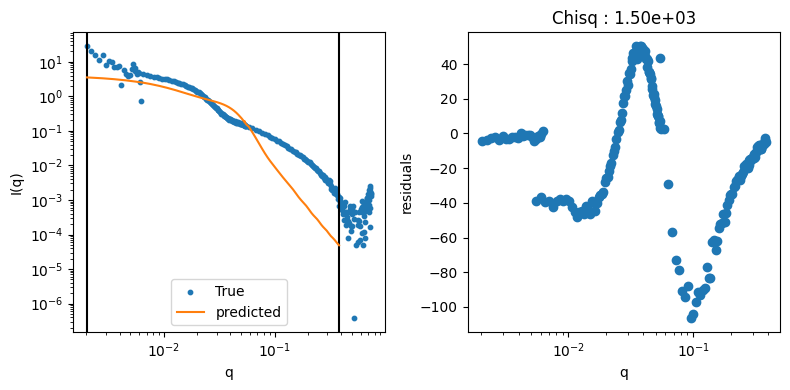

Plotting and printing fitted models of data 1
          scale 1.6733544004693702e-07
         v_core 13643.24977348233
       v_corona 8037.032177649488
    radius_core 140.2400615902492
 radius_core_pd 0.2268318708065405
             rg 13.095414296245789
  d_penetration 0.945947502997099


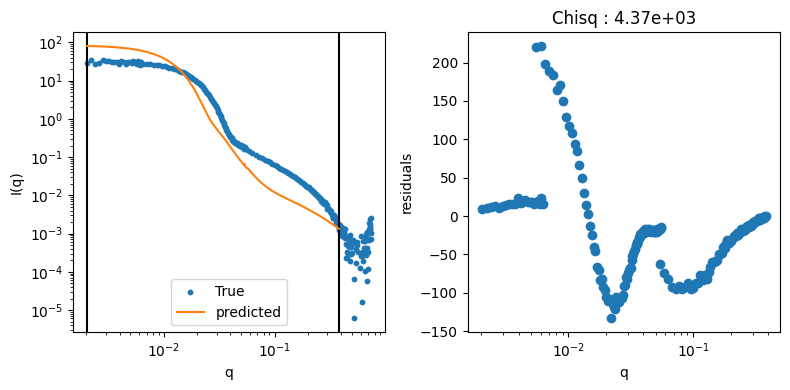

In [30]:
from sasmodels.direct_model import DirectModel

all_pars = problem.model_parameters()
models = [m for m in problem.models]
model_pars = all_pars["models"][0]
free_pars = all_pars["freevars"]
for i, data in enumerate(datasets):
    # extract fitted params of an fname
    fitted_params = {}
    file_pars = model_pars.copy()
    for name, param in free_pars.items():
        file_pars[name].set(param[i].value)
    for name, param in file_pars.items():
        fitted_params[name] = param.value
    print('Plotting and printing fitted models of data %d'%i)
    for key in fitted_params_keys:
        print('{:>15} {:>15}'.format(key, fitted_params[key]))

    kernel = DirectModel(data, sas_model)
    Iq_fitted = kernel(**fitted_params) 
    fig, axs = plt.subplots(1,2, figsize=(4*2, 4))
    fig.subplots_adjust(wspace=0.3)
    axs[0].scatter(data.x, data.y, s=10, label='True')

    # plot predicted and data curve
    min_max_mask = (data.x >= data.qmin) & (data.x <= data.qmax)
    q_mask = data.x[min_max_mask]
    axs[0].axvline(x=data.qmin, color='k')
    axs[0].axvline(x=data.qmax, color='k')   
    axs[0].plot(q_mask, Iq_fitted, label='predicted', color='tab:orange')
    axs[0].set_xlabel('q')
    axs[0].set_ylabel('I(q)')
    axs[0].legend()
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    # plot residuals
    expt = models[i].fitness
    expt.update()
    # residuals = expt.residuals()
    residuals = (Iq_fitted - data.y[min_max_mask]) / data.dy[min_max_mask]
    axs[1].scatter(q_mask, residuals)
    axs[1].set_title('Chisq : %.2e'%problem._models[i].chisq())
    axs[1].set_xlabel('q')
    axs[1].set_ylabel('residuals')
    axs[1].set_xscale('log')
    # axs[1].set_yscale('log')
    plt.tight_layout()
    plt.show()

In [31]:
for key, param in expt.parameters().items():
    if key in fitted_params_keys:
        print('{:>15} {:>15}'.format(key, param.value))

          scale 1.6733544004693702e-07
         v_core 13643.24977348233
       v_corona 8037.032177649488
    radius_core 140.2400615902492
 radius_core_pd 0.2268318708065405
             rg 13.095414296245789
  d_penetration 0.945947502997099
